In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import sys
import glob
import zipfile
import numpy as np
import statsmodels.api as sm
from collections import defaultdict, Counter
import networkx as nx

# Browsing Behaviors

In [2]:
import pandas as pd

taobao = pd.read_csv('/Users/chengjun/百度云同步盘/Writing/TaobaoResearch//BrowsePurchase/1Userbrowsetime.csv',
                     names = ['time', 'user', 'item'])

In [5]:
taobao['hour'] = [int(i) for i in (taobao.time/3600)]
taobao['minute'] = [int(i) for i in (taobao.time/60)]

taobao = taobao.sort_values(by = ['hour','user', 'time'], ascending=[1, 1, 1])

In [6]:
taobao[:3]

,time,user,item,hour,minute
341618,845,1,109,0,14
343061,846,1,109,0,14
347403,851,1,118,0,14


In [150]:
len(taobao)

32373278

## Flow Network

In [7]:
taobao = taobao.sort_values(by = ['hour','user', 'time'], ascending=[1, 1, 1])

In [161]:
taobao[:10]

,time,user,item,minute
8995662,13547,0,93,225
9079510,13649,0,29,227
9081466,13652,0,68,227
9081958,13652,0,82,227
9082339,13653,0,29,227
9082699,13653,0,86,227
10498364,15721,0,101,262
10501649,15724,0,94,262
10503340,15725,0,75,262
10503708,15725,0,70,262


In [8]:
len(taobao)

32373278

In [9]:
taobao0 = taobao[taobao['hour']==0]
len(taobao0)

2421981

In [10]:
C = np.array(taobao0[['user', 'item']])

In [57]:
a = C[:20]
a

array([[  1, 109],
       [  1, 109],
       [  1, 118],
       [  1, 115],
       [  1, 106],
       [  1, 108],
       [  1, 118],
       [  1, 107],
       [  1, 110],
       [  3, 147],
       [  3, 147],
       [  3, 137],
       [  3, 235],
       [  3, 161],
       [  3, 137],
       [  3, 230],
       [  3, 182],
       [  3, 146],
       [  3, 205],
       [  3, 160]])

In [56]:
zip(a[:-1], a[1:])

[(array([  1, 109]), array([  1, 109])),
 (array([  1, 109]), array([  1, 118])),
 (array([  1, 118]), array([  1, 115])),
 (array([  1, 115]), array([  1, 106])),
 (array([  1, 106]), array([  1, 108])),
 (array([  1, 108]), array([  1, 118])),
 (array([  1, 118]), array([  1, 107])),
 (array([  1, 107]), array([  1, 110])),
 (array([  1, 110]), array([  3, 147])),
 (array([  3, 147]), array([  3, 147])),
 (array([  3, 147]), array([  3, 137])),
 (array([  3, 137]), array([  3, 235])),
 (array([  3, 235]), array([  3, 161])),
 (array([  3, 161]), array([  3, 137])),
 (array([  3, 137]), array([  3, 230])),
 (array([  3, 230]), array([  3, 182])),
 (array([  3, 182]), array([  3, 146])),
 (array([  3, 146]), array([  3, 205])),
 (array([  3, 205]), array([  3, 160]))]

In [117]:
 def constructFlowNetwork (C):
    '''
    C is an array of two dimentions, e.g., 
    C = np.array([[user1, item1], 
                  [user1, item2], 
                  [user2, item1], 
                  [user2, item3]])
    '''
    E=defaultdict(lambda:0)
    E[('source',C[0][1])]+=1
    E[(C[-1][1],'sink')]+=1
    F=zip(C[:-1],C[1:])
    for i in F:
        if i[0][0]==i[1][0]:
            E[(i[0][1],i[1][1])]+=1
        else:
            E[(i[0][1],'sink')]+=1
            E[('source',i[1][1])]+=1
    G=nx.DiGraph()
    for i,j in E.items():
        x,y=i
        G.add_edge(x,y,weight=j)
    return G

def flowBalancing(G):
    H = G.copy()
    O = G.out_degree(weight='weight')
    I = G.reverse().out_degree(weight='weight')
    for i in O:
        if i =='sink' or i=='source':
            continue
        de = I[i]-O[i]
        if de > 0:
            H.add_edge(i,'sink',weight=de)
        elif de < 0:
            H.add_edge('source',i,weight=-de)
    return H


def networkDissipate(G):
    D=defaultdict(lambda:[0,0,0])#toSink,totalflow,fromSource
    for x,y in G.edges():
        w = G[x][y].values()[0]
        if y == 'sink':
            D[x][0]+=w
        if x != 'source':
            D[x][1]+=w
        elif x == 'source':
            D[y][2]+=w
    return D

def networkDissipate(G):
    D=defaultdict(lambda:[0,0,0])#toSink,totalflow,fromSource
    for x,y in G.edges():
        w = G[x][y].values()[0]
        if x == 'source':
            D[y][2]+=w
        elif y == 'sink':
            D[x][0]+=w
        elif x != 'source':
            D[x][1]+=w    
    return D

In [103]:
D=defaultdict(lambda:[0,0,0])#toSink,totalflow,fromSource
for x, y in [[1, 2], ['source', 2], [1, 'sink']]:
    if x == 'source':
        D[y][2]+=1
    if y == 'sink':
        D[x][0]+=1
    if x != 'source':
        D[x][1]+=1   
D

defaultdict(<function __main__.<lambda>>, {1: [1, 2, 0], 2: [0, 0, 1]})

In [118]:
g = constructFlowNetwork(C)

In [119]:
h = flowBalancing(g)

In [120]:
nx.info(g)

'Name: \nType: DiGraph\nNumber of nodes: 426227\nNumber of edges: 1756917\nAverage in degree:   4.1220\nAverage out degree:   4.1220'

In [121]:
nx.info(h)

'Name: \nType: DiGraph\nNumber of nodes: 426227\nNumber of edges: 1756917\nAverage in degree:   4.1220\nAverage out degree:   4.1220'

In [122]:
edge_df = pd.DataFrame(h.edges(), columns = ['from', 'to'])
a = edge_df[edge_df['from']=='source']
len(a)

94613

In [123]:
a[:3]

,from,to
1334980,source,0
1334981,source,2
1334982,source,4


In [124]:
h['source'][0].values()[0]

3

In [125]:
di = networkDissipate(h)

In [126]:
toSink,totalflow,fromSource = np.array(di.values()).T

In [139]:
toflow = totalflow-toSink

In [133]:
def log_binning(x, y, bin_count=20):
    max_x = np.log10(max(x))
    max_y = np.log10(max(y))
    max_base = max([max_x,max_y])
    xx = [i for i in x if i>0]
    min_x = np.log10(np.min(xx))
    bins = np.logspace(min_x,max_base,num=bin_count)
    bin_means_y = (np.histogram(x,bins,weights=y)[0] / np.histogram(x,bins)[0])
    bin_means_x = (np.histogram(x,bins,weights=x)[0] / np.histogram(x,bins)[0])
    return bin_means_x,bin_means_y

def alloRegressPlot(xdata,ydata,col,mark,xlab,ylab, loglog):
    ti, di = log_binning(xdata,ydata)
    x=np.log(ti+0.1);y=np.log(di+0.1);
    xx = sm.add_constant(x, prepend=True)
    res = sm.OLS(y,xx).fit()
    constant=res.params[0];beta=res.params[1]; r2=res.rsquared
    plt.plot(xdata,ydata,mark,color=col, alpha = 0.3)
    plt.plot(ti, di, 'ro')
    xs = np.linspace(min(ti+1),max(ti+1),100)
    plt.plot(xs,np.exp(constant)*xs**beta,color='r',linestyle='-', 
             label = '$\\gamma$ = '+ str(np.round(beta,2)) + ' , ' \
         + '$R^2$ = ' + str(np.round(r2,3)))
    plt.legend(loc = 0)
    if loglog == True:
        plt.xscale('log');plt.yscale('log')
    plt.xlabel(xlab, fontsize = 20);plt.ylabel(ylab, fontsize = 20)
    minx,maxx=plt.xlim(); miny,maxy=plt.ylim()


## Dissipation Law

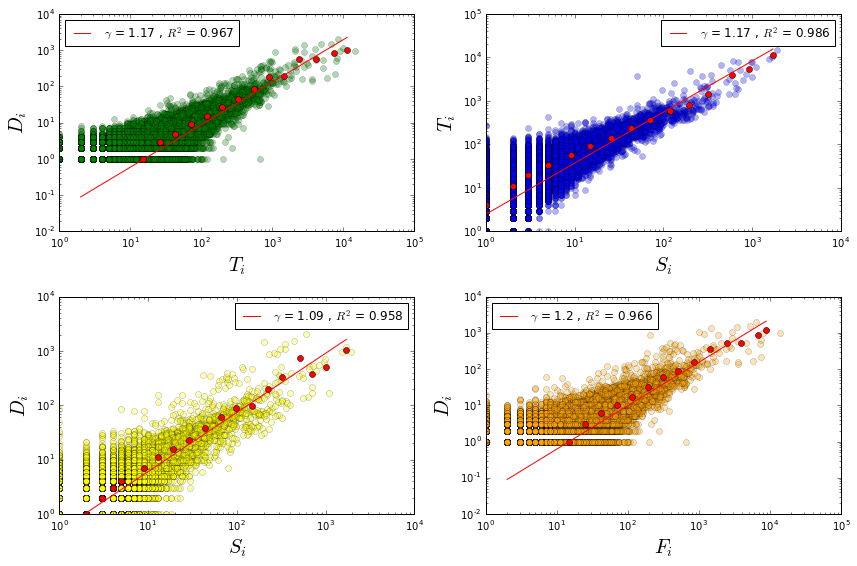

In [144]:
fig = plt.figure(figsize=(12, 8),facecolor='white')
ax = fig.add_subplot(2,2,1)
alloRegressPlot(totalflow,toSink,'g','o','$T_i$','$D_i$', True)
ax = fig.add_subplot(2,2,2)
alloRegressPlot(fromSource,totalflow,'b','o','$S_i$','$T_i$', True)
ax = fig.add_subplot(2,2,3)
alloRegressPlot(fromSource,toSink,'yellow','o','$S_i$','$D_i$', True)
ax = fig.add_subplot(2,2,4)
alloRegressPlot(toflow,toSink,'orange','o','$F_i$','$D_i$', True)
plt.tight_layout()


## Allowmetric Growth

In [147]:
taobao_groupby = taobao.groupby('minute')
uv = taobao_groupby['user'].nunique()
pv = taobao_groupby['item'].count()

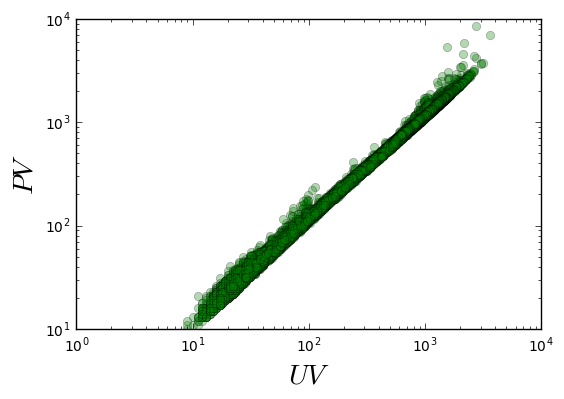

In [125]:
plt.plot(uv, pv, 'go', alpha = 0.3)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('$UV$', fontsize = 20)
plt.ylabel('$PV$', fontsize = 20)

plt.show()

In [153]:
def alloRegressPlot(xdata,ydata,col,mark,xlab,ylab, loglog):
    x=np.log(xdata+1);y=np.log(ydata+1);
    xx = sm.add_constant(x, prepend=True)
    res = sm.OLS(y,xx).fit()
    constant=res.params[0];beta=res.params[1]; r2=res.rsquared
    plt.plot(xdata,ydata,mark,color=col, \
             label = '$\\gamma$ = '+ str(np.round(beta,2)) + ' , ' \
         + '$R^2$ = ' + str(np.round(r2,3)))
    if loglog == True:
        plt.xscale('log');plt.yscale('log')
    plt.xlabel(xlab, fontsize = 20);plt.ylabel(ylab, fontsize = 20)
    minx,maxx=plt.xlim(); miny,maxy=plt.ylim()
    plt.legend(loc = 0)
    xs = np.linspace(min(xdata),max(xdata),100)
    plt.plot(xs,np.exp(constant)*xs**beta,color='r',linestyle='-')

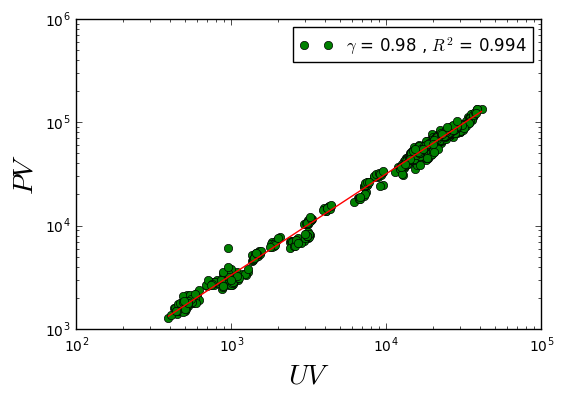

In [149]:
alloRegressPlot(uv,pv,'g','o','$UV$','$PV$', True)

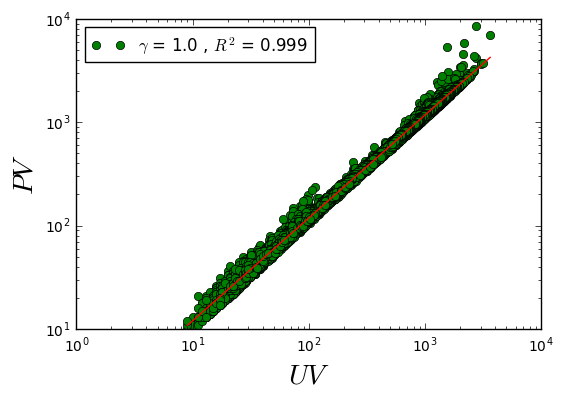

In [140]:
alloRegressPlot(uv,pv,'g','o','$UV$','$PV$', True)

# Purchasing Behaviors

In [145]:
bdf=pd.read_csv('/Users/chengjun/百度云同步盘/Writing/TaobaoResearch/BrowsePurchase/1Userpurchasetime.csv', 
                names = ['time', 'user', 'item'])

In [146]:
bdf[:3]

,time,user,item
0,0,66195,212085
1,0,270918,3040
2,0,403636,34546


In [147]:
bdf['hour'] = [int(i) for i in (bdf.time/3600)]
bdf['minute'] = [int(i) for i in (bdf.time/60)]

bdf = bdf.sort_values(by = ['hour','user', 'time'], ascending=[1, 1, 1])

In [148]:
len(bdf)

1465172

In [149]:
bdf = bdf.sort_values(by = ['hour','user', 'time'], ascending=[1, 1, 1]) 

In [151]:
bdf[:20]

,time,user,item,hour,minute
14852,847,1,109,0,14
68425,2322,6,314,0,38
68426,2322,6,367,0,38
68427,2322,6,302,0,38
13369,814,26,1052,0,13
13370,814,26,1032,0,13
13371,814,26,1045,0,13
13372,814,26,1028,0,13
84032,2659,37,1313,0,44
7926,679,38,1377,0,11


In [152]:
bdf_groupby = bdf.groupby('minute')
uv = bdf_groupby['user'].nunique()
pv = bdf_groupby['item'].count()

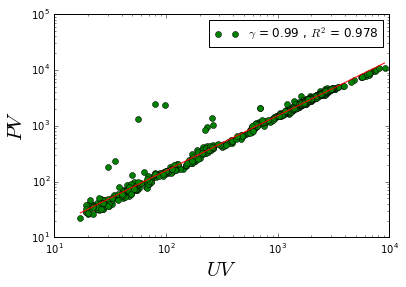

In [154]:
alloRegressPlot(uv,pv,'g','o','$UV$','$PV$', True)

In [155]:
bdf_groupby = bdf.groupby('hour')
uv = bdf_groupby['user'].nunique()
pv = bdf_groupby['item'].count()

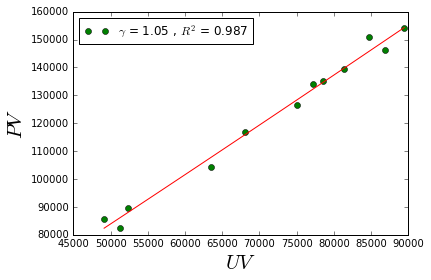

In [157]:
alloRegressPlot(uv,pv,'g','o','$UV$','$PV$', False)